# Описание проекта: Обнаружение мошеннических транзакций с кредитными картами

## Общая информация
Данные содержат транзакции по кредитным картам за 2 дня в сентябре 2013 года. Датасет характеризуется **сильным дисбалансом классов**: большинство транзакций легитимные, а мошеннические составляют менее 1% от общего объема.

**Цель**: Построить модель бинарной классификации для обнаружения мошеннических операций.

## Описание признаков
| Признак  | Тип данных | Описание                                                                 |
|----------|------------|-------------------------------------------------------------------------|
| **Time** | `float`    | Время транзакции в секундах относительно первой транзакции в датасете   |
| **V1-V28** | `float`  | Анонимизированные признаки, полученные после PCA-преобразования. Нормализованы (диапазон: [-10, 10]) |
| **Amount** | `float` | Сумма транзакции в долларах                                             |
| **Class** | `int`    | Целевая метка: `0` - легитимная транзакция, `1` - мошенническая         |

## Статистика классов
```python
Легитимные транзакции (Class = 0): 284,315 (99.83%)
Мошеннические транзакции (Class = 1): 492 (0.17%)

In [66]:
# Основные библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Модели
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Метрики
from sklearn.metrics import classification_report, precision_recall_curve, precision_recall_curve, average_precision_score, roc_curve

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Кросс-валидация и разбиние данных
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict

# Автоподбор гиперпараметров
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV

## Датафрейм

In [4]:
df = pd.read_csv('creditcard.csv')
pd.set_option('display.max_columns', None)  # Показывать все колонки

In [138]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Анализ датасета

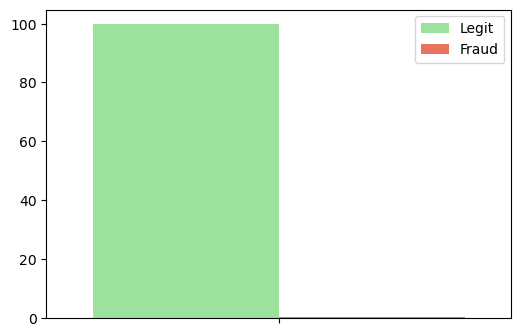

In [5]:
plt.figure(figsize=(6,4))
sns.barplot(hue=['Legit', 'Fraud'], y=[legit_percent, fraud_percent], palette=['Lightgreen', 'Tomato'])
plt.show()

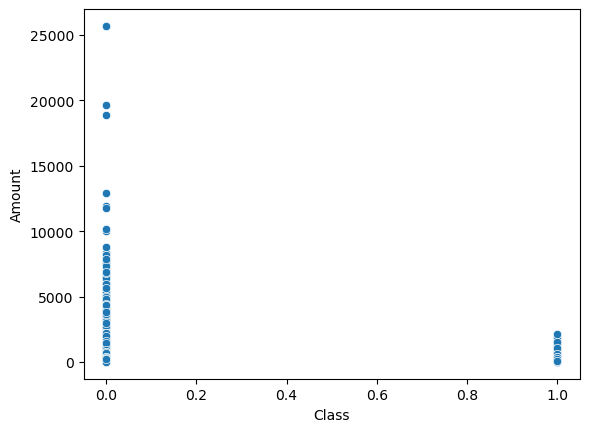

In [6]:
sns.scatterplot(y='Amount', x='Class', data=df)  # корреляция между Class и Amount
plt.show()

Замечание: Мошеннические транзакции не привышали сумму в 3000$

In [7]:
max_fraud_amount = df[df['Class'] == 1]['Amount'].max() # максимальное значение суммы мошеннической операции 
max_fraud_amount

2125.87

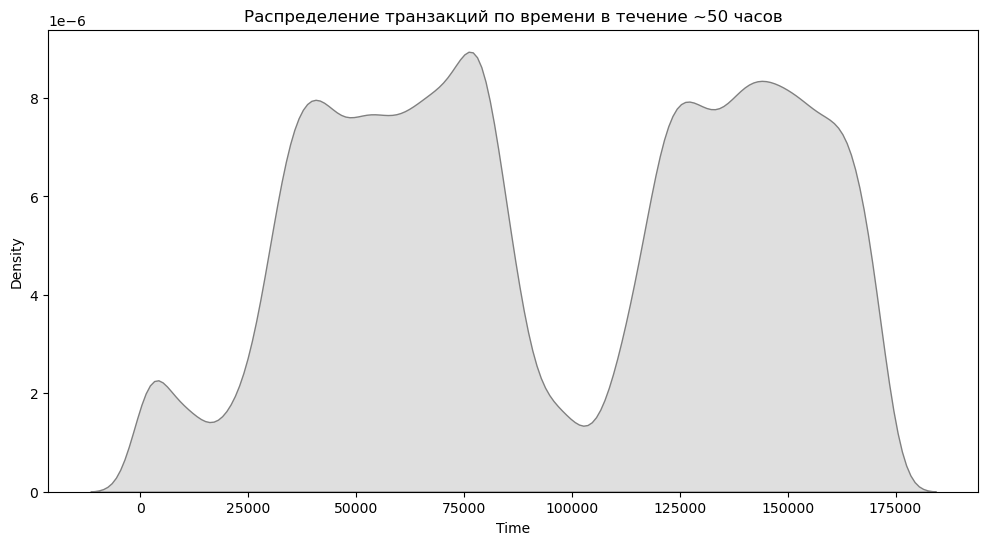

In [8]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x = 'Time',fill=True, color='grey')
plt.title('Распределение транзакций по времени в течение ~50 часов')
plt.show()

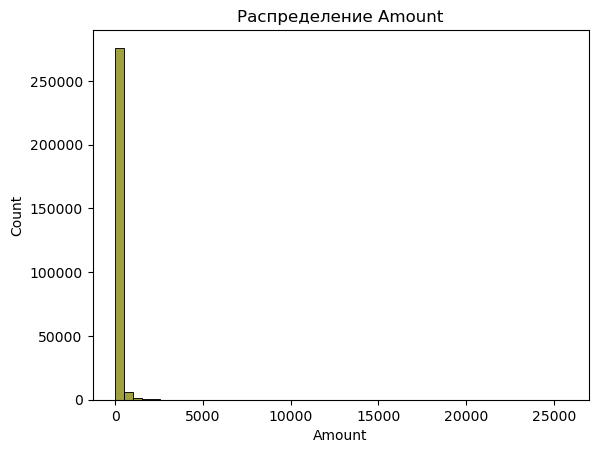

In [9]:
sns.histplot(df['Amount'], bins=50, color='olive')
plt.title('Распределение Amount')
plt.show()

Из графика следует, что основное кол-во транзакций были на небольшую сумму. Как раз все fraud транзакции были на небольшую сумму.

In [10]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Подготовка данных к обучению

Разбиение датасета на обучающие и тестовые наборы данных.

In [78]:
X = df.drop(['Class', 'Time', 'Amount'], axis=1)
y = df['Class']
print(X, y)
print(len(X) == len(y))

               V1         V2        V3        V4        V5        V6  \
0       -1.359807  -0.072781  2.536347  1.378155 -0.338321  0.462388   
1        1.191857   0.266151  0.166480  0.448154  0.060018 -0.082361   
2       -1.358354  -1.340163  1.773209  0.379780 -0.503198  1.800499   
3       -0.966272  -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4       -1.158233   0.877737  1.548718  0.403034 -0.407193  0.095921   
...           ...        ...       ...       ...       ...       ...   
284802 -11.881118  10.071785 -9.834783 -2.066656 -5.364473 -2.606837   
284803  -0.732789  -0.055080  2.035030 -0.738589  0.868229  1.058415   
284804   1.919565  -0.301254 -3.249640 -0.557828  2.630515  3.031260   
284805  -0.240440   0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  -0.533413  -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9       V10       V11       V12       V13  \
0       0.239599  0.098698  0.363787  0.090794 -0.55160

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

## Функция для оценки моделей

In [60]:
def evaluate_model(model, X_train, y_train, X_test, y_test, threshold=None):
    """
    Функция для оценки классификаторов.
    с возможностью подбора порога классификации и построения PR-кривой.
    
    Параметры:
    
    model: обученная модель с методами predict_proba и/или predict
    X_train, y_train: обучающие данные
    X_test, y_test: тестовые данные
    threshold: вероятностный порог для классификации (если None, используется стандартный predict)
    plot_pr_curve: строить ли PR-кривую (по умолчанию True)
    
    """
    
    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]
    
    if threshold is not None:
        train_pred = (train_proba >= threshold).astype(int)
        test_pred = (test_proba >= threshold).astype(int)
    else:
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

    train_metrics = {
        'pr_auc': average_precision_score(y_train, train_proba),
        'classification_report': classification_report(y_train, train_pred, zero_division=0)
    }
    
    test_metrics = {
        'pr_auc': average_precision_score(y_test, test_proba),
        'classification_report': classification_report(y_test, test_pred, zero_division=0)
    }
    
    print('TRAIN')
    if threshold is not None:
        print(f"Использованный порог: {threshold}")
    print(f"PR-AUC: {round(train_metrics["pr_auc"], 4)}")
    print(train_metrics['classification_report'])
    
    print('TEST')
    if threshold is not None:
        print(f"Использованный порог: {threshold}")
    print(f"PR-AUC: {round(test_metrics["pr_auc"], 4)}")
    print(test_metrics['classification_report'])
    
    # PR-кривая
    precision_train, recall_train, _ = precision_recall_curve(y_train, train_proba)
    precision_test, recall_test, _ = precision_recall_curve(y_test, test_proba)
        
    plt.figure(figsize=(8, 6))
        
    plt.plot(recall_train, precision_train, label=f'Train (PR-AUC = {round(train_metrics["pr_auc"], 4)})')
    plt.plot(recall_test, precision_test, label=f'Test (PR-AUC = {round(test_metrics["pr_auc"], 4)})')
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

## Функция для подбора порога вероятности классификации

In [89]:
def find_best_threshold(model, X, y, cv):
    """
    Функция для подбора лучшего вероятности порога классификации.
    В качестве метрики подбора используется PR-AUC.
    
    Параметры:
    
    model: обученная модель с методами predict_proba и/или predict
    X_train, y_train: обучающие данные.
    cv: Количество фолдов для кросс-валидации.
    
    """
    # Кросс-валидация для подбора threshold
    y_proba_cv = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y, y_proba_cv)

    # максимизируем сумму precision и recall
    best_threshold = thresholds[np.argmax(precision + recall)]
    
    return best_threshold

## Логистическая регрессия

#### Модель логистической регрессии со взвешиванием классов

In [36]:
logr_model_balanced = LogisticRegression(
        class_weight='balanced',
        n_jobs=-1,
        max_iter=150
)

In [37]:
logr_model_balanced.fit(X=X_train,y=y_train)

LogisticRegression(class_weight='balanced', max_iter=150, n_jobs=-1)

TRAIN
Использованный порог: 0.9999972206611072
PR-AUC: 0.7212
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213238
           1       0.85      0.76      0.80       367

    accuracy                           1.00    213605
   macro avg       0.92      0.88      0.90    213605
weighted avg       1.00      1.00      1.00    213605

TEST
Использованный порог: 0.9999972206611072
PR-AUC: 0.7661
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71077
           1       0.89      0.81      0.85       125

    accuracy                           1.00     71202
   macro avg       0.94      0.90      0.92     71202
weighted avg       1.00      1.00      1.00     71202



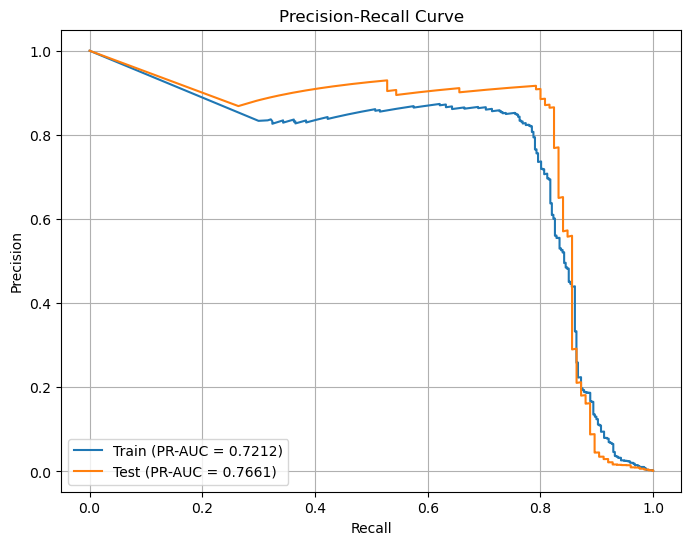

None


In [93]:
logr_model_balanced_eval = evaluate_model(logr_model, X_train, y_train, X_test, y_test, best_threshold)
print(logr_model_balanced_eval)

In [40]:
coef_logr_model_balanced = logr_model_balanced.coef_
print(f"shape {coef_logr_model_balanced.shape}")
print(coef_logr_model_balanced)

shape (1, 28)
[[ 0.3185901  -0.26256852  0.00897658  0.96440619  0.15243699 -0.29817332
   0.17652607 -0.68042557 -0.35362205 -0.74727868  0.58572037 -0.96017139
  -0.38946742 -1.27507595 -0.08651261 -0.45694355 -0.76350607 -0.351612
   0.17496635  0.1698492   0.28938801  0.43599636 -0.33679581 -0.11517113
   0.08086485 -0.29154506  0.88925878  0.31099447]]


## Boost

In [114]:
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    max_depth=2,
    random_state=101
)

In [116]:
xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=10
)

[0]	validation_0-aucpr:0.68292
[10]	validation_0-aucpr:0.81446
[20]	validation_0-aucpr:0.83327
[30]	validation_0-aucpr:0.83752
[40]	validation_0-aucpr:0.84207
[50]	validation_0-aucpr:0.84269
[60]	validation_0-aucpr:0.84503
[70]	validation_0-aucpr:0.84742
[80]	validation_0-aucpr:0.85211
[90]	validation_0-aucpr:0.85176
[99]	validation_0-aucpr:0.85326


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=101, ...)

TRAIN
PR-AUC: 0.9273
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213238
           1       0.97      0.83      0.89       367

    accuracy                           1.00    213605
   macro avg       0.98      0.92      0.95    213605
weighted avg       1.00      1.00      1.00    213605

TEST
PR-AUC: 0.8534
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71077
           1       0.95      0.80      0.87       125

    accuracy                           1.00     71202
   macro avg       0.98      0.90      0.93     71202
weighted avg       1.00      1.00      1.00     71202



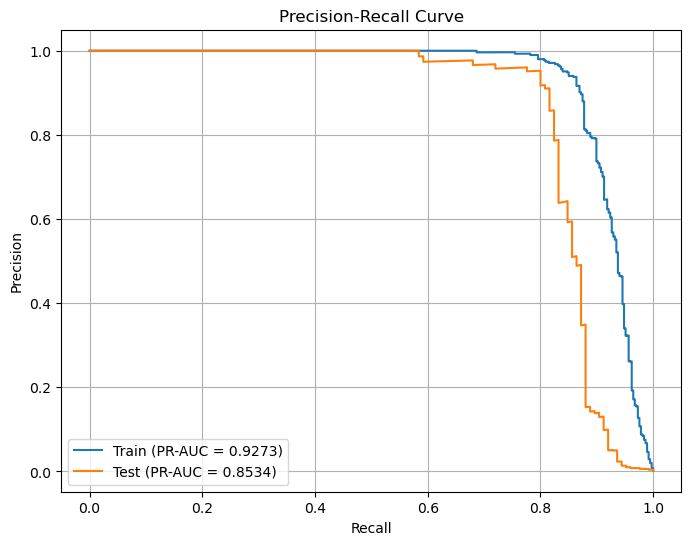

None


In [117]:
evaluate_xgb = evaluate_model(xgb, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
print(evaluate_xgb)

TRAIN
Использованный порог: 0.9999972206611072
PR-AUC: 0.9943
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213238
           1       0.00      0.00      0.00       367

    accuracy                           1.00    213605
   macro avg       0.50      0.50      0.50    213605
weighted avg       1.00      1.00      1.00    213605

TEST
Использованный порог: 0.9999972206611072
PR-AUC: 0.8602
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71077
           1       0.00      0.00      0.00       125

    accuracy                           1.00     71202
   macro avg       0.50      0.50      0.50     71202
weighted avg       1.00      1.00      1.00     71202



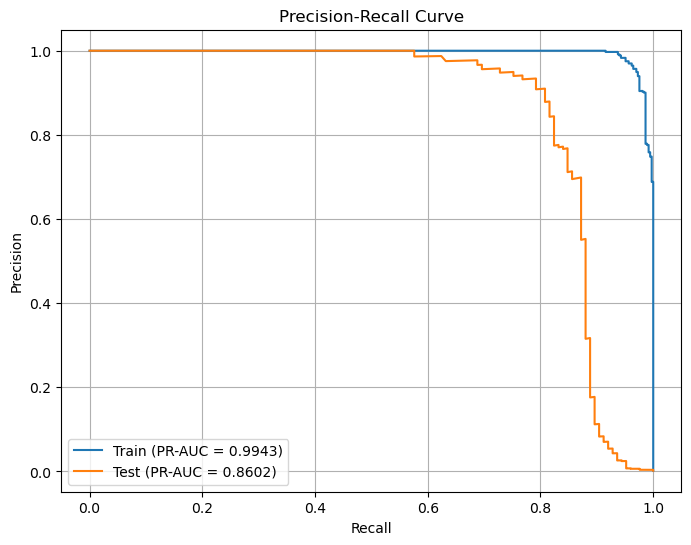

None


In [92]:
evaluate_xgb_threshold = evaluate_model_super(xgb, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, threshold=best_threshold)
print(evaluate_xgb_threshold)